<a href="https://colab.research.google.com/github/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/block_03_optical_flow_and_extrapolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nowcasting methods

In this notebook we show how to construct, visualize, apply verification metrics to and export a deterministic and probablistic (ensemble) nowcast using pysteps.


First we install pysteps and load the example data by running the [helper_input_data](https://github.com/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/helper_input_data.ipynb) notebook.

In [1]:
from google.colab import drive
import os
# mount the Google Drive folder
# don't attempt to remount if the drive is already mounted
if not os.path.exists("/content/mnt/MyDrive"):
  drive.mount("mnt")
%cd '/content/mnt/MyDrive/Colab Notebooks'
# run the data notebook to load the input dataset
%run helper_input_data.ipynb

/content/mnt/MyDrive/Colab Notebooks
/content/mnt/MyDrive/Colab Notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: Shapely 1.8.2
Uninstalling Shapely-1.8.2:
  Successfully uninstalled Shapely-1.8.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Shapely-1.8.2.tar.gz (198 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.2-cp37-cp37m-linux_x86_64.whl size=668931 sha256=d5a6ac5e4e49756a5998f1d6f1b126843cf99dd2a5ecb6a047a04991058ef2e6
  Stored in directory: /root/.cache/pip/wheels/2f/9e/07/e9e90942b4e31275785d2f7e455607bfe876e53906307f80cd
Successfully built shapely
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, htt

## Pre-processing steps
We will start with a few pre-processing steps that are the same for the deterministic and probablistic forecasts. These pre-processing steps resemble the steps from block 2 and 3 (so you could also continue with your scripts from those exercises). 

### Apply data transformations
The data from FMI has already been imported after running the [helper_input_data](https://github.com/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/helper_input_data.ipynb) notebook. The precip data is called `precip` and the metadata is called `metadata`.

In [3]:
from matplotlib import pyplot as plt
import numpy as np

from pysteps import motion
from pysteps.utils import transformation
from pysteps.visualization import plot_precip_field, quiver

# The precip variable consists of 16 time steps. We will use the first four
# to derive the motion field and make a nowcast, and the last twelve frames to
# validate the nowcasts (these will be the observations).
precip_for_forecast = precip[0:4]
precip_obs = precip[4:]

# When computing the optical flow, transforming the precipitation rates (mm/h)
# to dBR via the logarithmic transform shown in the previous exercise generally
# improves the reliability of the estimation.
precip_dbr, metadata_dbr = transformation.dB_transform(
    precip_for_forecast,
    metadata,
    threshold=0.1,
    zerovalue=-15.0
)

# Handling of NaN values has been explicitly implemented in Lucas-Kanade and VET,
# but not in DARTS. For this reason, we set all non-finite values to the minimum
# value before applying the optical flow.
precip_finite = precip_dbr.copy()
precip_finite[~np.isfinite(precip_finite)] = np.nanmin(precip_dbr)

print(metadata_dbr)

{'projection': '+proj=stere  +lon_0=25E +lat_0=90N +lat_ts=60 +a=6371288 +x_0=380886.310 +y_0=3395677.920 +no_defs', 'x1': 0.0049823258887045085, 'y1': 0.009731985162943602, 'x2': 759752.2852757066, 'y2': 1225544.6588913496, 'cartesian_unit': 'm', 'xpixelsize': 1999.348106, 'ypixelsize': 1999.25718, 'yorigin': 'upper', 'institution': 'Finnish Meteorological Institute', 'accutime': 5.0, 'unit': 'mm/h', 'transform': 'dB', 'zerovalue': -15.0, 'threshold': -10.0, 'zr_a': 223.0, 'zr_b': 1.53, 'timestamps': array([datetime.datetime(2016, 9, 28, 14, 45),
       datetime.datetime(2016, 9, 28, 14, 50),
       datetime.datetime(2016, 9, 28, 14, 55),
       datetime.datetime(2016, 9, 28, 15, 0),
       datetime.datetime(2016, 9, 28, 15, 5),
       datetime.datetime(2016, 9, 28, 15, 10),
       datetime.datetime(2016, 9, 28, 15, 15),
       datetime.datetime(2016, 9, 28, 15, 20),
       datetime.datetime(2016, 9, 28, 15, 25),
       datetime.datetime(2016, 9, 28, 15, 30),
       datetime.datetime(

### Determine the motion field
Determine the motion field (pick a method from block 3) and visualize it.

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-pa

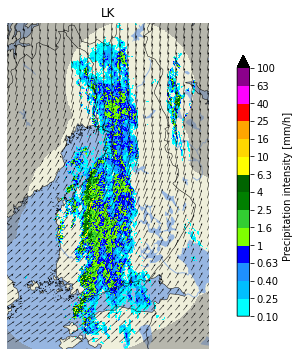

In [4]:
# Set the method
method = "LK"

# Determine the motion field (here, using the four most recent precipitation fields)
oflow = motion.get_method(method)
motion_field = oflow(precip_finite, verbose=False)

# Visualize it
plt.figure(figsize=(10, 6))
plot_precip_field(precip[-1], geodata=metadata, colorscale="STEPS-BE", title=method)
quiver(motion_field, geodata=metadata, step=15, quiver_kwargs={"scale": 50})

plt.show()

## Deterministic nowcasts

Will follow..

## Probabilistic nowcasts
In the second part, we are basically going to repeat the steps of the deterministic nowcast, but we will construct a probabilistic nowcast with 20 ensemble members and verify this nowcast accordingly. 
If time allows, you can also try to make a LINDA-P nowcast.

The first step is to make a probablistic nowcast using the STEPS approach that is explained in [the STEPS nowcast gallery example](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_steps_nowcast.html#stochastic-nowcast-with-steps). You can follow this example and adjust the code where necessary to make it work for our test case.

We are going to make an ensemble nowcast with 20 ensemble members and 12 lead times of 5 min (one hour in total). For a list of all options in the STEPS nowcast, see the [pysteps documentation](https://pysteps.readthedocs.io/en/latest/pysteps_reference/nowcasts.html#pysteps-nowcasts-steps).

In [5]:
from pysteps import nowcasts
from pysteps.postprocessing.ensemblestats import excprob

# Set nowcast parameters
n_ens_members = 20
n_leadtimes = 12
seed = 1234 # None gives a random seed number, but for reproducibility (i.e, 
# every nowcast will give the same perturbations) we set it to a fixed number.

# The STEPS nowcast
nowcast_method = nowcasts.get_method("steps")
precip_forecast = nowcast_method(
    precip_finite[-3:, :, :],
    motion_field,
    timesteps=n_leadtimes,
    n_ens_members=n_ens_members,
    n_cascade_levels=8,
    R_thr=metadata_dbr["threshold"],
    kmperpixel=metadata_dbr["xpixelsize"]/1000.0,
    timestep=metadata_dbr["accutime"],
    noise_method="nonparametric",
    vel_pert_method="bps",
    probmatching_method="cdf",
    mask_method="incremental",
    seed=seed,
    num_workers=4,
)

# Back-transform the results from dBR to rain rates
precip_forecast = transformation.dB_transform(
    precip_forecast, 
    threshold=metadata_dbr["threshold"], 
    inverse=True
    )[0]

/usr/local/lib/python3.7/dist-packages/pysteps/decorators.py:311: FutureWarning: Argument 'R_thr' has been renamed to 'precip_thr'. This will raise a TypeError in pysteps 1.8.0.
  FutureWarning,


Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 613x380
km/pixel:         1.999348106
time step:        5.0 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
ensemble size:            20
parallel threads:         4
number of cascade levels: 8
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
------------------------------

### Visualize the result
We are going to visualize the observations, ensemble mean of the probabilistic nowcast, individual ensemble members of the nowcast and the forecast probability of exceeding a certain threshold (1 mm/h here). An example on how to do this is provided in [the STEPS nowcast gallery example](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_steps_nowcast.html#stochastic-nowcast-with-steps).

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part 

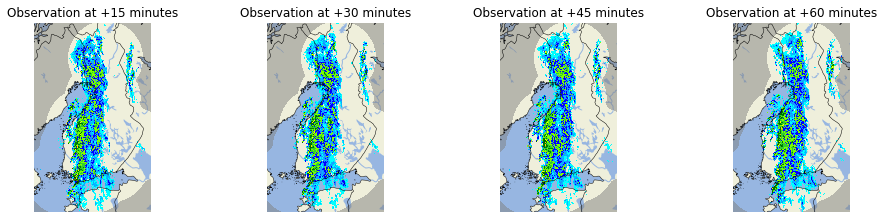

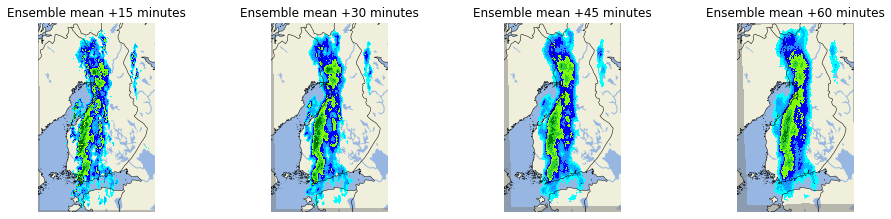

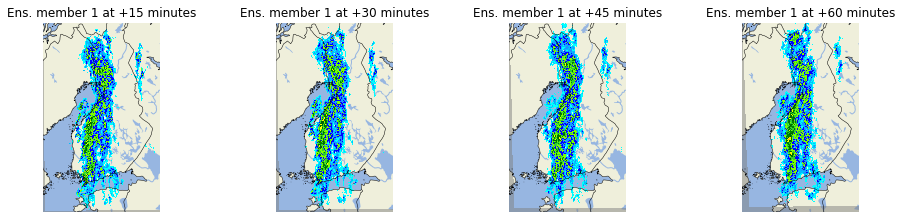

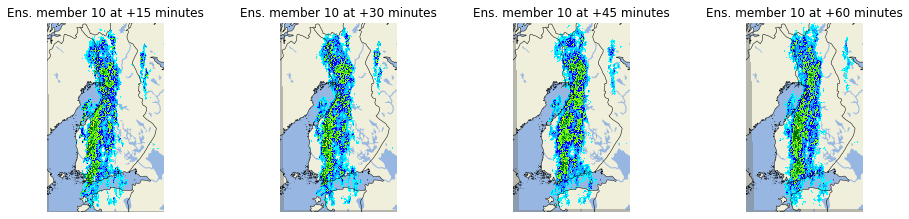

In [12]:
plt.figure(figsize=(16, 16))
# First plot the observations
for i, j in enumerate(range(2, 13, 3)):
    plt.subplot(4, 4, 1 + i)
    plot_precip_field(
        precip_obs[j], 
        geodata=metadata, 
        colorscale="STEPS-BE", 
        colorbar=False
        )
    plt.title(f"Observation at +{(j + 1) * 5} minutes")

# We'll plot the ensemble mean for four lead times
precip_forecast_mean = np.mean(precip_forecast[:, :, :, :], axis=0)

plt.figure(figsize=(16, 16))
for i, j in enumerate(range(2, 13, 3)):
    plt.subplot(4, 4, 1 + i)
    plot_precip_field(
        precip_forecast_mean[j], 
        geodata=metadata, 
        colorscale="STEPS-BE", 
        colorbar=False
        )
    plt.title(f"Ensemble mean +{(j + 1) * 5} minutes")

# Then, plot some realizations
plt.figure(figsize=(16, 16))
for i, j in enumerate(range(2, 13, 3)):
    plt.subplot(4, 4, 1 + i)
    plot_precip_field(
        precip_forecast[1,j], 
        geodata=metadata, 
        colorscale="STEPS-BE", 
        colorbar=False
        )
    plt.title(f"Ens. member 1 at +{(j + 1) * 5} minutes")

plt.figure(figsize=(16, 16))
for i, j in enumerate(range(2, 13, 3)):
    plt.subplot(4, 4, 1 + i)
    plot_precip_field(
        precip_forecast[10,j], 
        geodata=metadata, 
        colorscale="STEPS-BE", 
        colorbar=False
        )
    plt.title(f"Ens. member 10 at +{(j + 1) * 5} minutes")

plt.show()



As you can see from the two shown members of the ensemble, the stochastic forecast mantains the same variance as in the observed rainfall field. Hence, it gives a less smoothed outcome than the ensemble mean and also preserves high-intensity rainfall cells. Keep this in mind for the verification part where we will use verification metrics that can take the entire ensemble into account. 

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part 

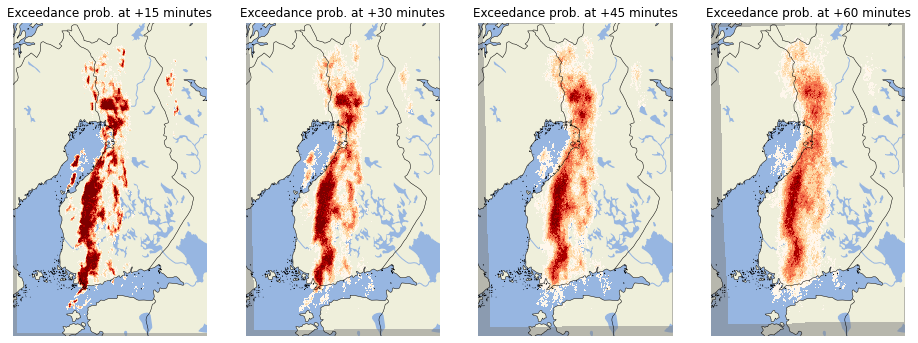

In [16]:
# Then plot the probability of exceeding 1 mm/h

plt.figure(figsize=(16, 10))
for i, j in enumerate(range(2, 13, 3)):
  # Compute exceedence probabilities for a 1.0 mm/h threshold
  P = excprob(precip_forecast[:, j, :, :], 1.0)
  plt.subplot(1, 4, 1 + i)
  plot_precip_field(
      P, 
      geodata=metadata, 
      ptype="prob",
      units="mm/h", 
      probthr=0.5,
      colorbar=False,
      )
  plt.title(f"Exceedance prob. at +{(j + 1) * 5} minutes")

plt.show()

### Ensemble forecast verification
Pysteps includes a number of verification metrics to help users to analyze the general characteristics of the nowcasts in terms of consistency and quality (or goodness). In contrast to the verification of the deterministic nowcast, we have a 20-member ensemble that we want to verify. As every member contains valuable information, it is better not to use the deterministic verification metrics on the ensemble mean, but to use a metric that can take the entire ensemble into account. 

Therefore, we will focus on the CRPS (continuous ranked probability score), which you can see as the mean absolute error of the ensemble. It compares the cdf of the ensemble with the observed rainfall. 

In addition, we will verify our probabilistic forecasts using the ROC curve, reliability diagrams, and rank histograms, as implemented in the [verification module](https://pysteps.readthedocs.io/en/latest/pysteps_reference/verification.html) of pysteps.

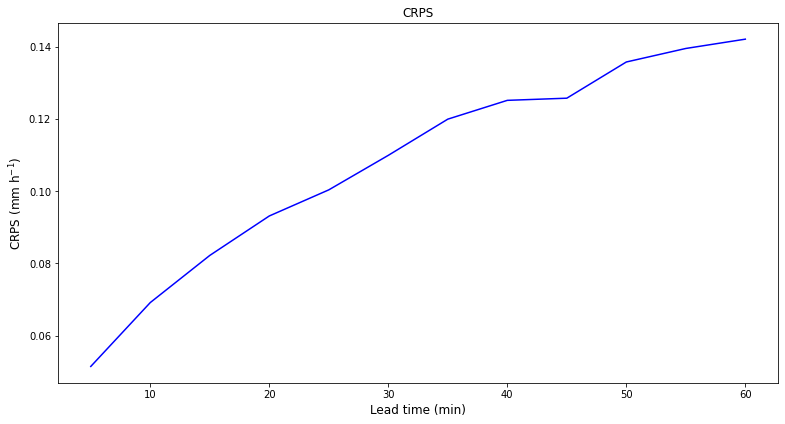

In [17]:
from pysteps import verification
from pysteps.postprocessing import ensemblestats

# Determine the CRPS
CRPS = []
for lt in range(n_leadtimes):
    CRPS.append(verification.probscores.CRPS(precip_forecast[:,lt,:,:],precip_obs[lt,:,:]))

# Plot it
fig = plt.figure(figsize = (10,5))
fig1 = fig.add_gridspec(1, 1, bottom = 0.0, top = 1.00, left = 0.0, right = 1.0) 
ax1 = fig.add_subplot(fig1[0,0])

# Plot the CRPS for both lead times
ax1.plot(
    (np.arange(n_leadtimes)+1)*5,
    CRPS,
    color="blue",
    )

ax1.set_xlabel("Lead time (min)", fontsize=12)
ax1.set_ylabel(r"CRPS (mm h$^{-1}$)", fontsize=12)

ax1.set_title("CRPS")

plt.show()


The [examples gallery](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_ensemble_verification.html#sphx-glr-auto-examples-plot-ensemble-verification-py) contains some ensemble verification examples that you could follow. For the subsequent verification metrics, we'll focus on a exceedance threshold of 1 mm/h. Try out some other thresholds and see how this influences the results.

In [21]:
print(roc)

([1.0, 0.11742482604756652, 0.08470512828414183, 0.05811767751160196, 0.03763165841843495, 0.014988567519429053, 0.006052127180953672, 0.0020153213728837586, 0.0005608386695181101, 6.163062302396815e-05], [1.0, 0.735283310060998, 0.645550084515323, 0.5494965826412875, 0.4517527743073418, 0.30234438156831045, 0.19592856617917248, 0.11089880208716102, 0.039611964430072755, 0.0023517307268317777], 0.8259948833610884)


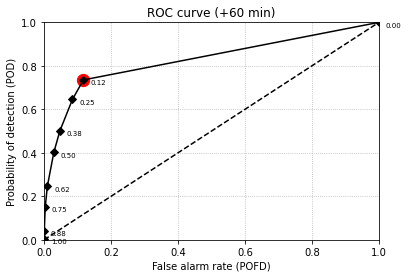

In [22]:
# We start with determining the exceedance probability in the forecast for a
# threshold of 1 mm/h for 1-h lead time (the last lead time in the forecast).
probability_forecast = ensemblestats.excprob(
    precip_forecast[:, -1, :, :], 
    1.0, 
    ignore_nan=True)

# ROC curve
roc = verification.ROC_curve_init(1.0, n_prob_thrs=9)
verification.ROC_curve_accum(
    ROC=roc, 
    P_f=probability_forecast, 
    X_o=precip_obs[-1, :, :],
    )
fig, ax = plt.subplots()
verification.plot_ROC(roc, ax, opt_prob_thr=True)
ax.set_title("ROC curve (+%i min)" % (n_leadtimes * timestep))
plt.show()

TypeError: ignored

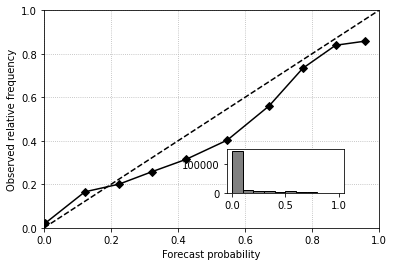

In [26]:
# Reliability diagram
reldiag = verification.reldiag_init(1.0)
verification.reldiag_accum(
    reldiag=reldiag, 
    P_f=probability_forecast, 
    X_o=precip_obs[-1, :, :],
)
fig, ax = plt.subplots()
verification.plot_reldiag(reldiag, ax)
ax.set_title("Reliability diagram (+%i min)" % (n_leadtimes * timestep))
plt.show()

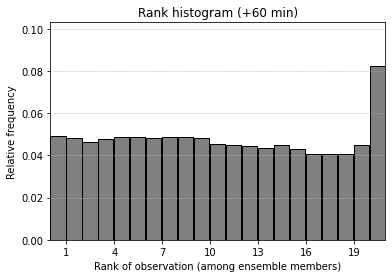

In [27]:
# Rank histogram
rankhist = verification.rankhist_init(precip_forecast.shape[0], 1.0)
verification.rankhist_accum(
    rankhist, 
    precip_forecast[:, -1, :, :], 
    precip_obs[-1, :, :]
    )
fig, ax = plt.subplots()
verification.plot_rankhist(rankhist, ax)
ax.set_title("Rank histogram (+%i min)" % (n_leadtimes * timestep))
plt.show()

## LINDA-P Forecast
Lagrangian INtegro-Difference equation model with
Autoregression (LINDA) combines extrapolation, S-PROG, STEPS, ANVIL,
integro-difference equation (IDE) and cell tracking methods. It can produce
both deterministic and probabilistic nowcasts. LINDA is specifically designed
for nowcasting intense localized rainfall. For this purpose, it is expected to
give better forecast skill than S-PROG or STEPS.

In [32]:
# Compute the probabilistic LINDA nowcast
nowcast_linda = nowcasts.linda.forecast(
    precip_fields=precip_for_forecast[-3:, :, :],
    advection_field=motion_field,
    timesteps=n_leadtimes,
    max_num_features=15,
    add_perturbations=True,
    num_ens_members=20,
    num_workers=4,
    seed=seed,
    measure_time=True,
)[0]

/usr/local/lib/python3.7/dist-packages/pysteps/decorators.py:311: FutureWarning: Argument 'precip_fields' has been renamed to 'precip'. This will raise a TypeError in pysteps 1.8.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pysteps/decorators.py:311: FutureWarning: Argument 'advection_field' has been renamed to 'velocity'. This will raise a TypeError in pysteps 1.8.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pysteps/decorators.py:311: FutureWarning: Argument 'num_ens_members' has been renamed to 'n_ens_members'. This will raise a TypeError in pysteps 1.8.0.
  FutureWarning,


Computing LINDA nowcast
-----------------------

Inputs
------
dimensions:           613x380
number of time steps: 3

Methods
-------
nowcast type:         ensemble
feature detector:     blob
extrapolator:         semilagrangian
kernel type:          anisotropic

Parameters
----------
number of time steps:       12
ARI model order:            1
localization window radius: 76.0
error dist. window radius:  57.0
error ACF window radius:    95.0
ensemble size:              20
parallel workers:           4
seed:                       1234

Detecting features... found 15 blobs in 2.56 seconds.
Transforming to Lagrangian coordinates... 0.29 seconds.
Estimating the first convolution kernel... 41.68 seconds.
Estimating the ARI(p,1) parameters... 0.38 seconds.
Estimating the second convolution kernel... 24.08 seconds.
Estimating forecast errors... Computing nowcast for time step 1... done.
2.52 seconds.
Estimating perturbation parameters... 

/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (1) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


69.49 seconds.
Computing nowcast for time step 1... 28.31 seconds.
Computing nowcast for time step 2... 28.82 seconds.
Computing nowcast for time step 3... 28.83 seconds.
Computing nowcast for time step 4... 28.65 seconds.
Computing nowcast for time step 5... 28.67 seconds.
Computing nowcast for time step 6... 28.60 seconds.
Computing nowcast for time step 7... 28.66 seconds.
Computing nowcast for time step 8... 28.73 seconds.
Computing nowcast for time step 9... 28.78 seconds.
Computing nowcast for time step 10... 28.84 seconds.
Computing nowcast for time step 11... 28.59 seconds.
Computing nowcast for time step 12... 28.56 seconds.


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part 

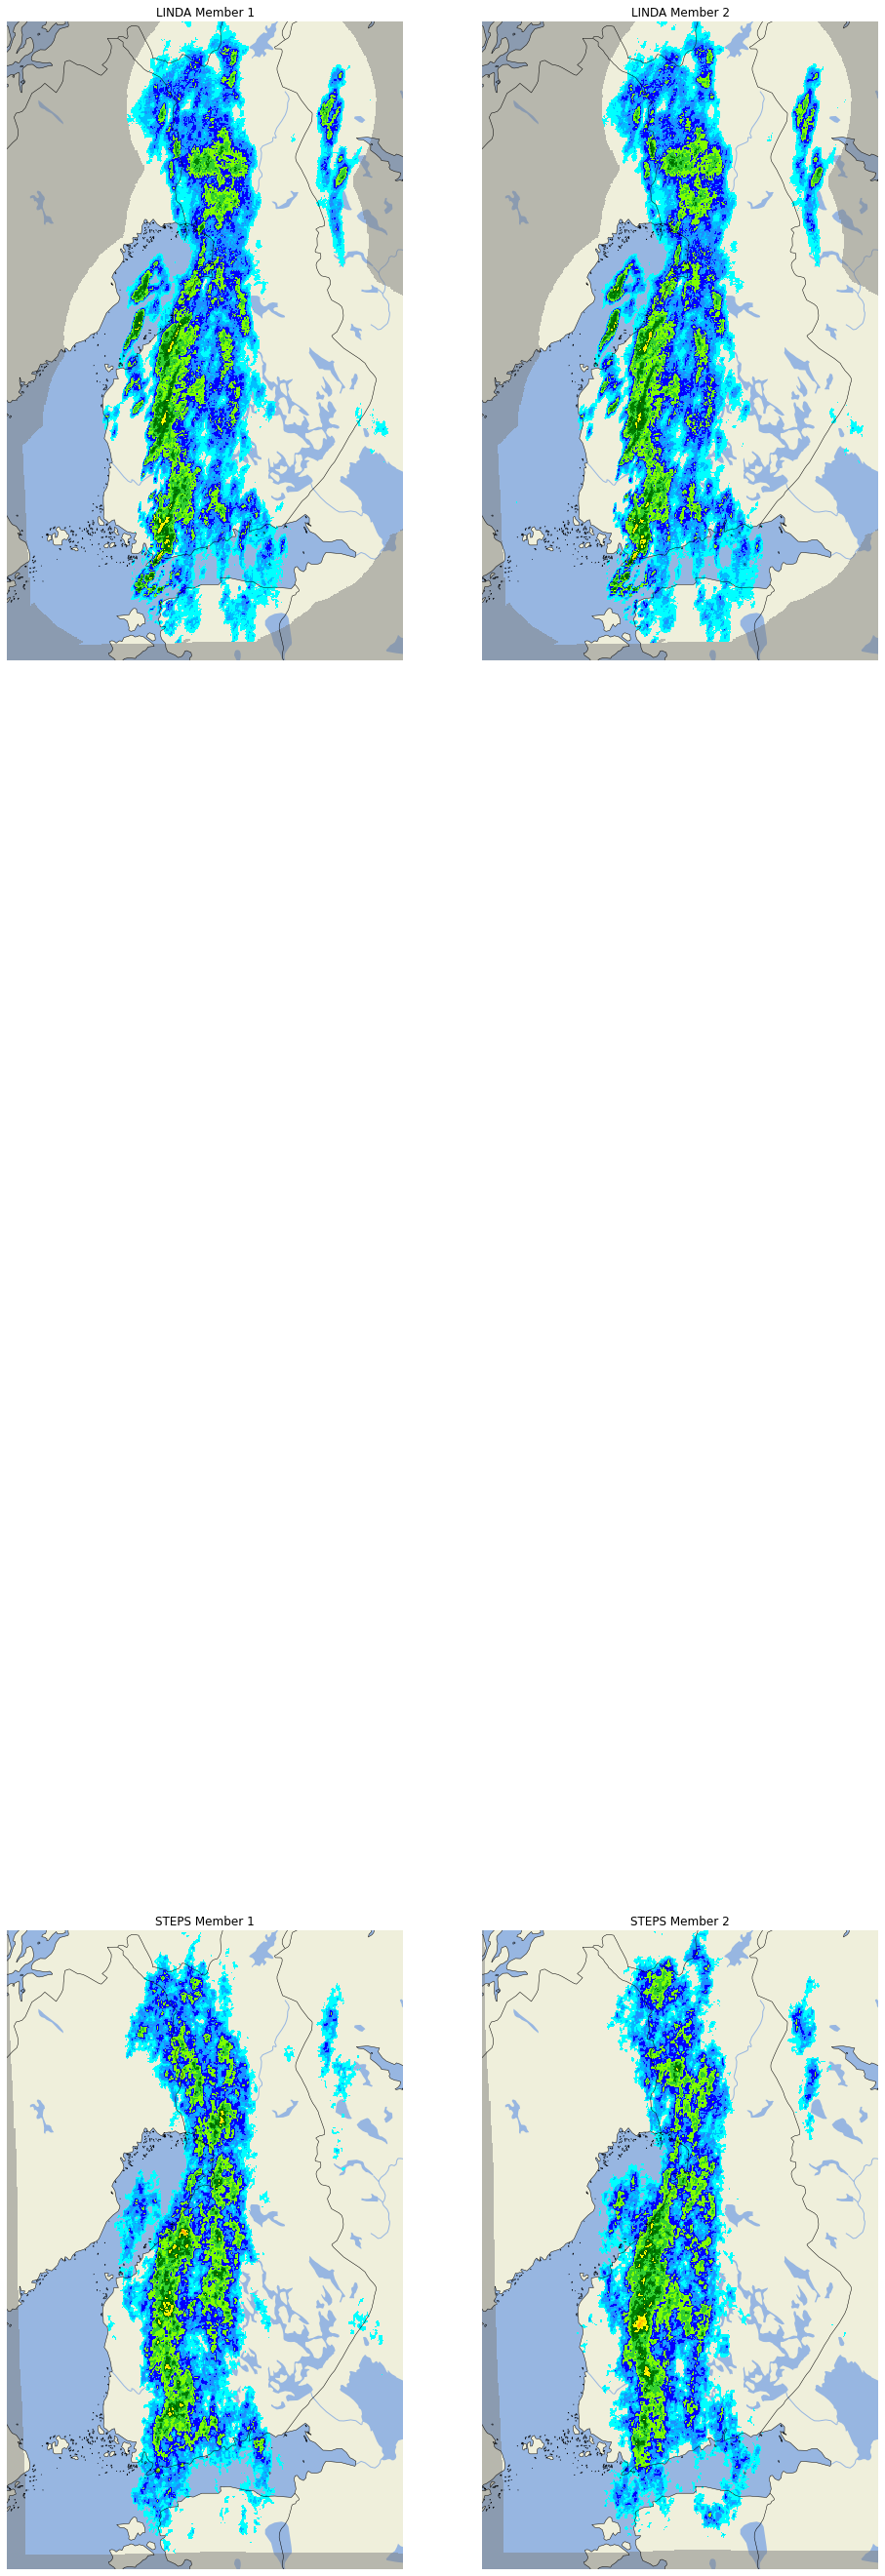

In [33]:
# Plot two ensemble members of both nowcasts for the last lead time (+60 min)
# Feel free to try out some other lead times and some verification metrics.
fig = plt.figure(figsize = (16,66))
for i in range(2):
    ax = fig.add_subplot(2, 2, i + 1)
    ax = plot_precip_field(
        nowcast_linda[i, -1, :, :], 
        geodata=metadata, 
        colorbar=False, 
        axis="off", 
        colorscale="STEPS-BE",
    )
    ax.set_title(f"LINDA Member {i+1}")

for i in range(2):
    ax = fig.add_subplot(2, 2, 3 + i)
    ax = plot_precip_field(
        precip_forecast[i, -1, :, :], 
        geodata=metadata, 
        colorbar=False, 
        axis="off", 
        colorscale="STEPS-BE",
    )
    ax.set_title(f"STEPS Member {i+1}")

## References


[1] 